# **Project :** Brain Tumor Detector

## **Introduction**

A brain tumor is a collection, or mass, of abnormal cells in your brain. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside your skull to increase. This can cause brain damage, and it can be life-threatening. The idea of this problem is to try and build an AI-powered system to be able to not just detect brain tumor but also find out specific type of tumors by looking at Brain MRI Scans. This will be a multi-class classification problem to classify each brain MRI scan image into 1 out of 4 classes using deep learning models for CV.

## **The dataset**

Final dataset contains 7022 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary. The size of the images in this dataset is different and you can resize them all to 128x128 to make the models run faster. Dataset is already divided into train and test folders for convenience. Build models on the train dataset and check performance on the test data using CNNs, Transfer Learning, Data Augmentation etc.

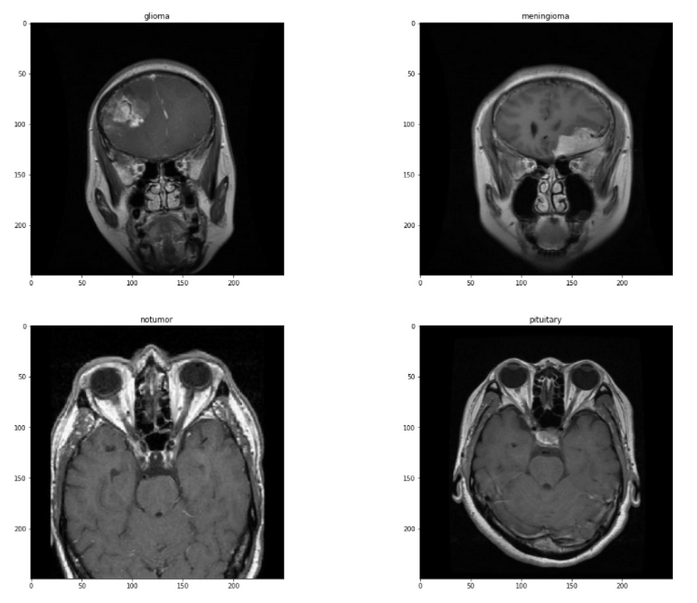

## **Key Objectives**

* Train-Test Datasets are already prepared in the folders when you load them. Do split the train dataset into 80:20 (train-validation split – use seed=42). Resize images to 128x128 for quicker modeling.
  
* Build a basic CNN model from scratch (2-3) layers which should serve as a baseline model and give you around close to 90-91% accuracy easily.

* Try different approaches of data augmentation, more complex CNN architectures, pre-trained models, transfer learning along with NN training approaches like early stopping, dynamic learning rates etc. to see if you can push the model performance to 98-99% (remember in healthcare, model accuracy >= 98% is usually desired).

* Showcase model performance on test data using confusion matrix, classification reports.

**Helper Notebook:** Use this notebook to load the data quickly and get started (uses memory efficient version by loading data into tensorflow datasets) OR you could use this tutorial to use traditional ImageDataGenerators (though the first approach is preferred and more memory efficient).

Data Augmentation examples: https://www.tensorflow.org/tutorials/images/transfer_learning#use_data_augmentation OR check out the hints in the helper notebook towards the end.

**Models:** Feel free to build your own models from scratch and maybe experiment with pre-trained models e.g VGG, ResNet etc.



## 1. Import Libraries

In [1]:
#===========================================================================
# For data manipulation, plotting, and miscellaneous
#===========================================================================
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
#plt.style.use("fivethirtyeight")
import plotly.express as px 
import datetime 
import os 
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import calendar
from datetime import datetime
import copy

from PIL import Image
import cv2  # For Image processing
import pickle 
from tqdm import tqdm
from glob import glob
#===============================================================================================
# Import Keras models, layers, activation functions
#===============================================================================================
import tensorflow as tf
tf.random.set_seed(3)
import keras
from keras import datasets, models
from keras.models import Sequential
from keras.layers import Rescaling
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, ReLU, LeakyReLU, Dropout
from keras import regularizers
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.math import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import VGG16
#============================================================================
# From sklearn import required classes
#============================================================================
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder,LabelEncoder
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils.class_weight import compute_class_weight


## **2. Load the Dataset and Perform Visualization**

**Here keras generator has been used in order to load the images in terms of batches, because loading all those thousands of images in to the RAM is impossible, so using the "Generators" concept in python to load images in batches**

https://keras.io/api/data_loading/image/

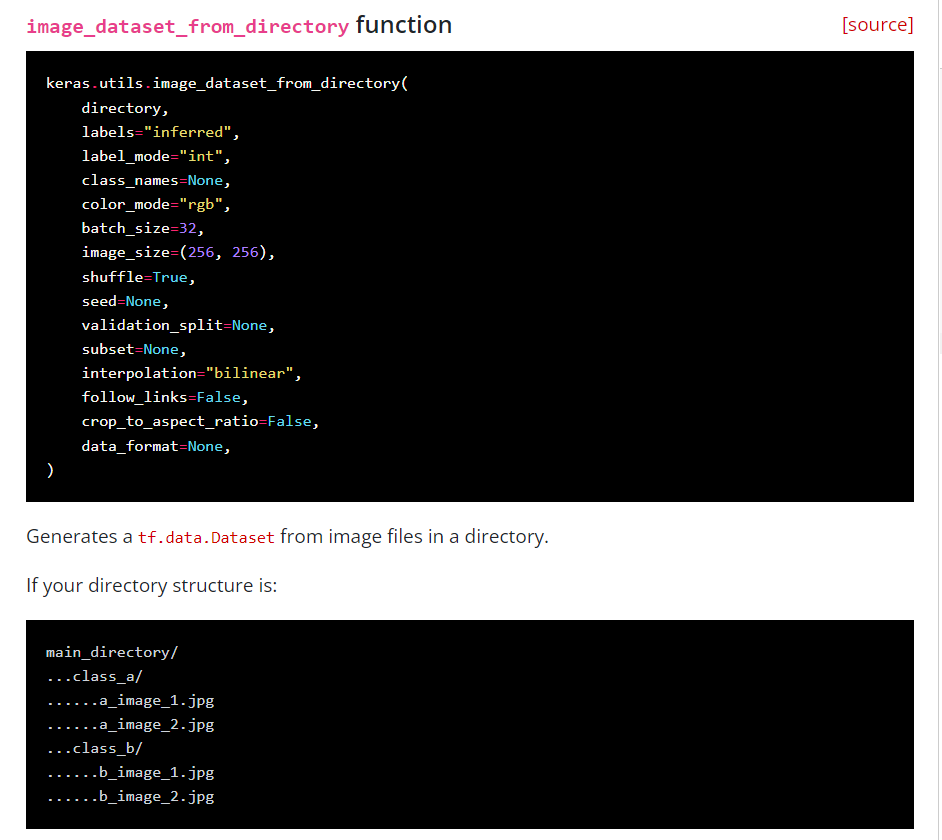

### 2.1. Load the Dataset

In [2]:
random_seed = 3

IMG_DIMS = (128, 128)           # image dimensions
BATCH_SIZE = 32                 # batch size
IMG_SHAPE = IMG_DIMS + (3,)     # Size to resize images, this will be used consistenly in CNN model building as well
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']    # class labels

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format

def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",         # Directory where the data is located
        validation_split=0.2,
        subset="training",    # Subset of the data to return. One of "training", "validation", or "both". 
        class_names=classes,
        seed=random_seed,
        image_size=IMG_DIMS,  # Size to resize images to after they are read from disk, specified as (height, width).
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",           # Directory where the data is located
        validation_split=0.2,
        subset="validation",    # Subset of the data to return. One of "training", "validation", or "both". 
        class_names=classes,
        seed=random_seed,
        image_size=IMG_DIMS,    # Size to resize images to after they are read from disk, specified as (height, width).
        batch_size=BATCH_SIZE,
    )

    #train_ds = train_ds.prefetch(buffer_size=25)
    #val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",             # Directory where the data is located
        class_names=classes,
        seed=random_seed,
        image_size=IMG_DIMS,     # Size to resize images to after they are read from disk, specified as (height, width).
        batch_size=32,
    )

    test_labels = []
    predictions = []

    #for imgs, labels in tqdm(test_ds.take(100),
                             #desc='Predicting on Test Data'):
    for imgs, labels in test_ds.take(100):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions

In [3]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order by default but we have set our own order with the `class_names` parameter.

In [4]:
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [5]:
for img, labels in train_ds.take(1):    # The take(1) method retrieves the first batch of data (the first set of images and their corresponding labels).
  print(img.shape)
  print(labels.shape)
  break

(32, 128, 128, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension referes to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


**Check number of batches**

In [6]:
print(f"Number of batches in training set: {len(train_ds)}")
print(f"Number of batches in validation set: {len(val_ds)}")

total_images = len(train_ds) * BATCH_SIZE + len(val_ds) * BATCH_SIZE
print(f"Total number of images used in training and validation: {total_images}")

Number of batches in training set: 143
Number of batches in validation set: 36
Total number of images used in training and validation: 5728


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",             # Directory where the data is located
        class_names=classes,
        seed=random_seed,
        image_size=IMG_DIMS,     # Size to resize images to after they are read from disk, specified as (height, width).
        batch_size=32,
    )

print(f"Number of batches in test set: {len(test_ds)}")
total_test_images = len(test_ds) * 32
print(f"Total number of images in test set: {total_test_images}")

Found 1311 files belonging to 4 classes.
Number of batches in test set: 41
Total number of images in test set: 1312


### 2.2. Visualize the Dataset

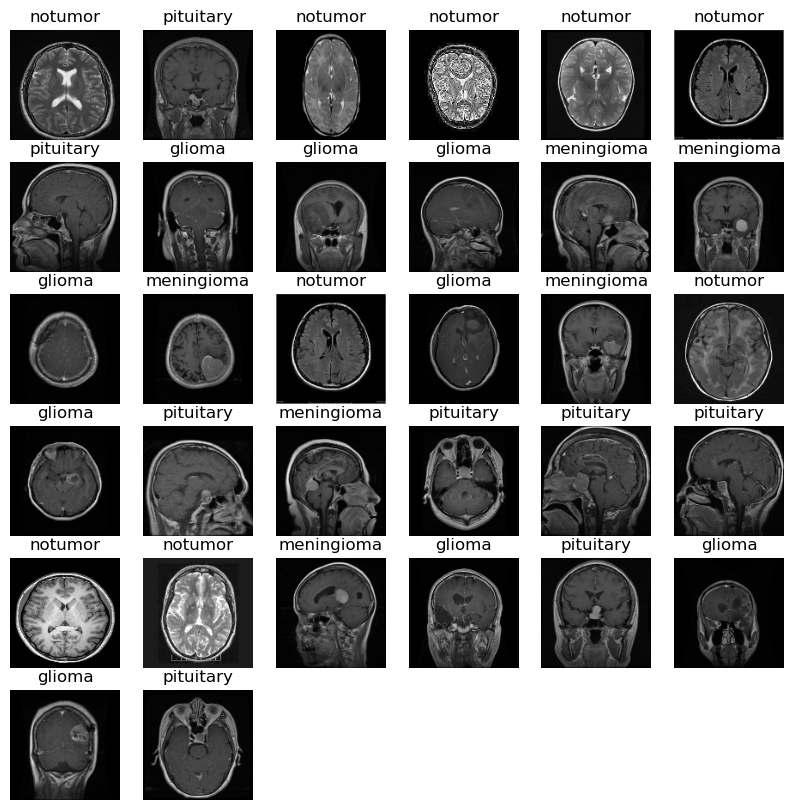

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # The take(1) method retrieves the first batch of data (the first set of images and their corresponding labels).
  for i in range(BATCH_SIZE):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes[labels[i]])
    plt.axis("off")

In [9]:
labels   #  # single batch consists of 32 images as mentioned in the batch size parameter above

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([2, 3, 2, 2, 2, 2, 3, 0, 0, 0, 1, 1, 0, 1, 2, 0, 1, 2, 0, 3, 1, 3,
       3, 3, 2, 2, 1, 0, 3, 0, 0, 3])>

### 2.3. Class Distribution in the Dataset

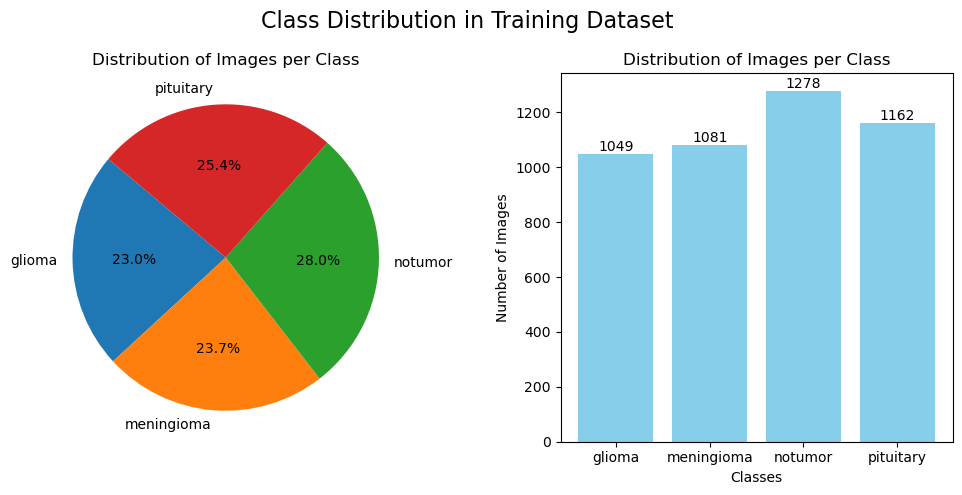

In [10]:
# Get the class names and count how many images belong to each class
def plot_class_distribution(dataset, class_names,dataset_title):
    class_counts = {class_name: 0 for class_name in class_names}
    
    # Iterate over the dataset to get the labels
    for images, labels in dataset:
        for label in labels:
            class_counts[class_names[label]] += 1

    # Prepare data for plots
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    # Pie Plot
    plt.figure(figsize=(10, 5))

    # Add a super title for the dataset
    plt.suptitle(f"Class Distribution in {dataset_title}", fontsize=16)
    
    plt.subplot(1, 2, 1)
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title("Distribution of Images per Class")

    # Bar Plot
    plt.subplot(1, 2, 2)
    bars = plt.bar(labels, counts, color='skyblue')
    plt.bar_label(bars)  # This adds the labels to the bars
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title("Distribution of Images per Class")
   
    plt.tight_layout()
    plt.show()

# Call the function with the training dataset
plot_class_distribution(train_ds, classes, "Training Dataset")

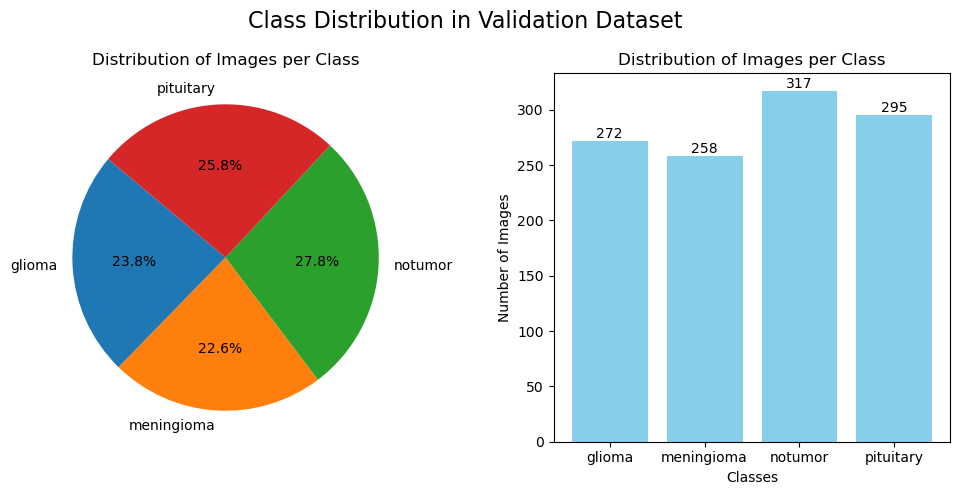

In [11]:
plot_class_distribution(val_ds, classes, "Validation Dataset")

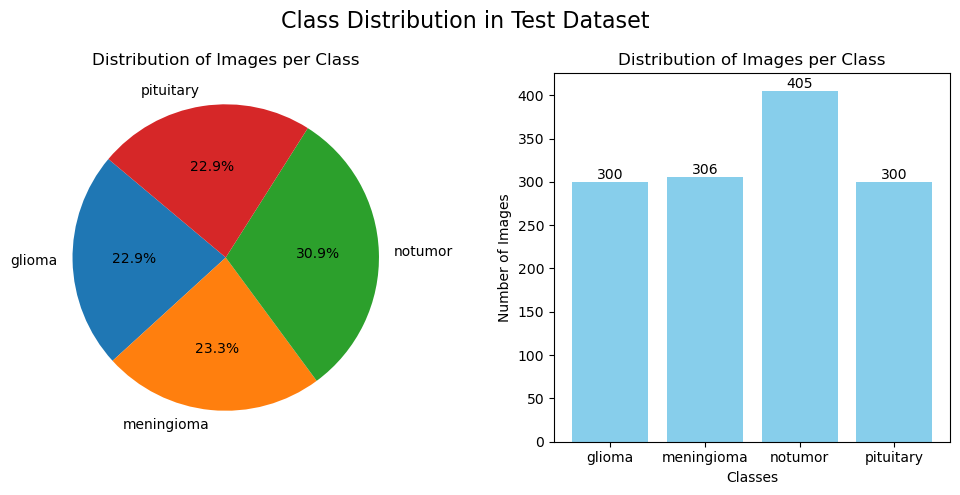

In [12]:
plot_class_distribution(test_ds, classes, "Test Dataset")

### 2.4. Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the `[0, 1]` by using a Rescaling layer.

In [13]:
normalization_layer = Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling map:

In [14]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`. output value may change based on the imgae pixel value
print(np.min(first_image), np.max(first_image))

0.0 0.959804


Or, you can include the layer inside your model definition, which can simplify deployment. We will use the second approach here.

Note: we previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

### 2.5. Calculate class weights

In [15]:
def calculate_class_weights(train_ds):
    # Extract class labels from the training dataset
    cls_train = []
    
    for _, labels in train_ds:
        cls_train.extend(labels.numpy())  # Convert labels to numpy and extend the list

    cls_train = np.array(cls_train)  # original class labels

    # Compute class weights
    class_weight = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(cls_train),
                                         y=cls_train)

    # Create a dictionary for class weights
    class_weight_dict = {i: weight for i, weight in enumerate(class_weight)}

    return class_weight_dict

# Calculate class weights
class_weight_dict = calculate_class_weights(train_ds)
print(class_weight_dict)

{0: 1.0891325071496663, 1: 1.0568917668825162, 2: 0.8939749608763693, 3: 0.9832185886402753}


## **3. Build CNN Model**

### 3.1. Create CNN Model

In [66]:
l2reg_val = 1e-5  # for l2- regularization
num_classes = len(classes)

#================================================================
# create CNN model
model = Sequential()

#========================================================================================
# Step # 1 : Rescaling layer to normalize the pixel values in image to [0,1] range
#========================================================================================
model.add(Rescaling(1./255, input_shape=IMG_SHAPE))  # input shape is defined here, no need to give input shape in the conv2d layer

#========================================================================================
# Step # 2 : Feature Extraction
#========================================================================================
# Convolutional layer #1
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_1' ))
                                                             # output shape will be : (n-f+2p)/s+1, here f=kernel size=3
#model.add(BatchNormalization(name='BatchNorm_1'))            # to make training of NN faster and more stable
model.add(MaxPooling2D(pool_size=(2,2), strides=2, name ='Maxpool_1')) # output shape will be : (n-f+2p)/s+1 , here f=poolsize=2

# Convolutional layer #2
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_2'))
#model.add(BatchNormalization(name='BatchNorm_2'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, name ='Maxpool_2'))

# Convolutional layer #3
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_3'))
#model.add(BatchNormalization(name='BatchNorm_3'))
model.add(MaxPooling2D(pool_size=(2,2), strides=2, name ='Maxpool_3'))

#================================================================
# Step # 3 : Image Classification
#================================================================
# fully connected layer
model.add(Flatten(name='Flatten'))

model.add(Dense(128, activation='relu',name = 'Dense_1'))
model.add(Dropout(0.2, name='Dropout_1'))                                      

model.add(Dense(128, activation='relu',name = 'Dense_2'))
model.add(Dropout(0.2, name='Dropout_2'))                                                                     

model.add(Dense(num_classes, activation='softmax', name = 'Output'))  
#================================================================

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 Conv2D_1 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 Maxpool_1 (MaxPooling2D)    (None, 112, 112, 64)      0         
                                                                 
 Conv2D_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 Maxpool_2 (MaxPooling2D)    (None, 56, 56, 128)       0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 56, 56, 128)       147584    
                                                                 
 Maxpool_3 (MaxPooling2D)    (None, 28, 28, 128)      

### 3.2. Compile the model

In [67]:
opt_adam = Adam(learning_rate=0.001)
opt_rmsprop = RMSprop(learning_rate=0.001) 

model.compile(optimizer=opt_adam,
              loss='SparseCategoricalCrossentropy',      
              metrics=['accuracy'])

### 3.3 Train the model

Since i used image_dataset_from_directory(), hence no need to manually specify steps_per_epoch. The model will automatically handle the correct number of steps based on the size of the dataset and batch size.

In [68]:
epochs = 100
steps_train = len(train_ds)
steps_val = len(val_ds)

earlystop = EarlyStopping(monitor='val_accuracy', patience = 5, mode='max', restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    #class_weight=class_weight_dict,
                    #class_weight={0:1.5, 1:2.0, 2:0.7, 3:0.8},
                    callbacks = [earlystop]
                   )

Epoch 1/100
143/143 [==============================] - 35s 208ms/step - loss: 0.8230 - accuracy: 0.6532 - val_loss: 0.5640 - val_accuracy: 0.7688
Epoch 2/100
143/143 [==============================] - 25s 174ms/step - loss: 0.4171 - accuracy: 0.8466 - val_loss: 0.3676 - val_accuracy: 0.8643
Epoch 3/100
143/143 [==============================] - 24s 168ms/step - loss: 0.2817 - accuracy: 0.8958 - val_loss: 0.2764 - val_accuracy: 0.9002
Epoch 4/100
143/143 [==============================] - 25s 175ms/step - loss: 0.2062 - accuracy: 0.9267 - val_loss: 0.2768 - val_accuracy: 0.9002
Epoch 5/100
143/143 [==============================] - 24s 166ms/step - loss: 0.1448 - accuracy: 0.9475 - val_loss: 0.2656 - val_accuracy: 0.9203
Epoch 6/100
143/143 [==============================] - 24s 166ms/step - loss: 0.1091 - accuracy: 0.9606 - val_loss: 0.3137 - val_accuracy: 0.9089
Epoch 7/100
143/143 [==============================] - 24s 167ms/step - loss: 0.0838 - accuracy: 0.9713 - val_loss: 0.2315 -

### 3.4. Plot Training history (loss, accuracy) 

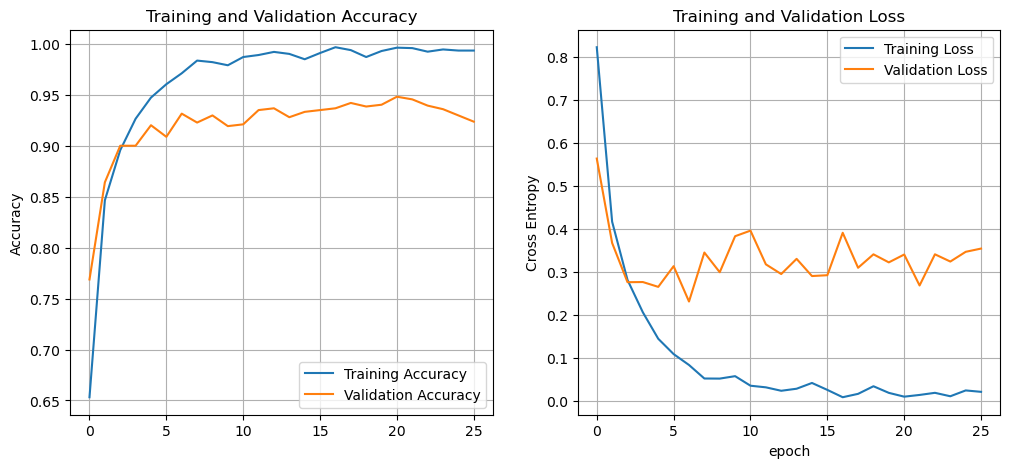

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

### 3.5. Prediction for Test dataset

In [70]:
y_true, y_pred_probabilities = eval_model_on_test(model)

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 1s 520ms/step


In [71]:
#y_true, y_pred_probabilities

In [72]:
len(y_true)

1311

In [73]:
len(y_pred_probabilities)

1311

In [74]:
len(np.argmax(y_pred_probabilities, axis=1))

1311

### 3.7. Classification Report & Confusion Matrix

Confusion Matrix:
 [[275  22   0   3]
 [ 17 269  11   9]
 [  0   1 403   1]
 [  1   2   0 297]]
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

      glioma       0.94      0.92      0.93       300
  meningioma       0.91      0.88      0.90       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311

--------------------------------------------------------------------------------


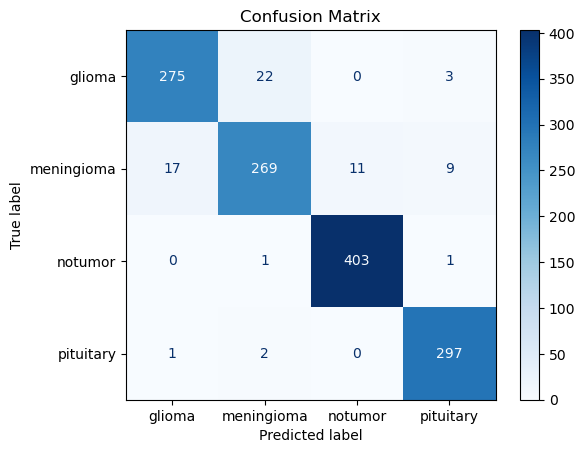

In [75]:
# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probabilities, axis=1)
# Calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", confusion)
print("-"*80)
# Calculate precision, recall, and f1-score
report = classification_report(y_true, y_pred, target_names=classes)
print("\nClassification Report:\n", report)

print("-"*80)
#============================================================================================
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
plt.style.use("default")
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix')
plt.grid(visible=False)
plt.show();

## **4. Fine tuning method : CNN model using VGG16 pretrained model**

![alt text](https://i.imgur.com/EyeXqiB.png)

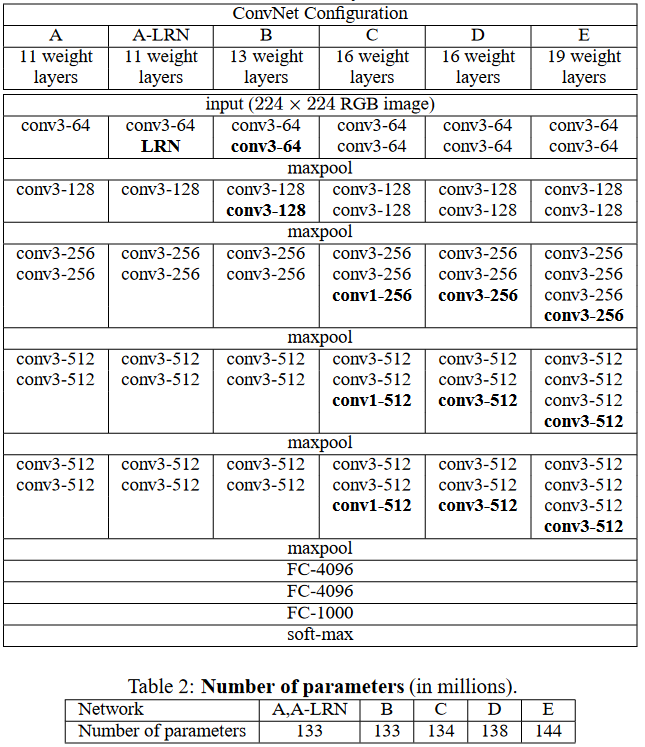

Source : VERY DEEP CONVOLUTIONAL NETWORKS
FOR LARGE-SCALE IMAGE RECOGNITION
Karen Simonyan∗ & Andrew Zisserman+
Visual Geometry Group, Department of Engineering Science, University of Oxford
{karen,az}@robots.ox.ac.uk

Published as a conference paper at ICLR 2015

**The 16 in VGG16 refers to 16 layers that have weights. In VGG16 there are thirteen convolutional layers, five Max Pooling layers, and three Dense layers which sum up to 21 layers but it has only sixteen weight layers i.e., learnable parameters layer.**

**Check the shape of the image**

Two ways to represent the image data as a three dimensional array

1. <b>  Channels Last:<b> Image data is represented in a three-dimensional array where the last channel represents the color channels, e.g. [rows][cols][channels].

2.  <b> Channels First:<b> Image data is represented in a three-dimensional array where the first channel represents the color channels, e.g. [channels][rows][cols].


### 4.1. Prepare the Training and validation data

In [26]:
img_height = 224
img_width  = 224

In [27]:
random_seed = 3
IMG_DIMS = (img_height, img_width)           # image dimensions
BATCH_SIZE = 32                 # batch size
IMG_SHAPE = IMG_DIMS + (3,)     # Size to resize images, this will be used consistenly in CNN model building as well
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']    # class labels

In [28]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [29]:
for img, labels in train_ds.take(1):    # The take(1) method retrieves the first batch of data (the first set of images and their corresponding labels).
  print(img.shape)
  print(labels.shape)
  break

(32, 224, 224, 3)
(32,)


In [30]:
import tensorflow.keras.backend as k
if k.image_data_format()=='channels_first': 
    input_shape=(3, img_height, img_width)
else:
    input_shape=(img_height, img_width,3)
input_shape

(224, 224, 3)

### 4.2. Get the VGG16 convolutional base model

In [31]:
# If include_top=True, you must provide the input shape (224, 224, 3) because VGG16's fully connected layers are designed 
# to take input from the 7x7 feature maps generated by the convolutional layers.
# If include_top=False, you can provide any input shape, and you have the freedom to add your own fully connected layers.

# input_shape: optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3)
# include_top: whether to include the 3 fully-connected layers at the top of the network.
# weights:"imagenet" (pre-training on ImageNet).

pretrained_conv_base = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
pretrained_conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 4.3. Set the trainable layers  in the VGG16 model

In [32]:
# Check the type of layers in the pretrained model
print(type(pretrained_conv_base.layers))
print(type(pretrained_conv_base.layers[0]))
print(type(pretrained_conv_base.layers[1]))
print(type(pretrained_conv_base.layers[2]))

<class 'list'>
<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>
<class 'keras.layers.convolutional.conv2d.Conv2D'>


In [33]:
# Check the layers names in the pretrained model
print(pretrained_conv_base.layers[0].name)
print(pretrained_conv_base.layers[1].name)
print(pretrained_conv_base.layers[2].name)

input_1
block1_conv1
block1_conv2


In [34]:
len(pretrained_conv_base.layers)

19

In [35]:
# Here we are NOT training up to block4
for layer in pretrained_conv_base.layers[:15]:
    layer.trainable = False

# Training only block5
for layer in pretrained_conv_base.layers[15:]:
    layer.trainable = True

# check the summary of which layers will be trained
for layer in pretrained_conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


### 4.4. Create CNN Model based on VGG16

In [36]:
num_classes = len(classes)
#================================================================
# create model
model_vgg = Sequential()

#========================================================================================
# Step # 1 : Rescaling layer to normalize the pixel values in image to [0,1] range
#========================================================================================
model_vgg.add(Rescaling(1./255, input_shape=IMG_SHAPE))  # input shape is defined here, no need to give input shape in the conv2d layer

#================================================================
# Step # 2 : Feature Extraction
#================================================================
model_vgg.add(pretrained_conv_base)

#================================================================
# Step # 3 : Image Classification
#================================================================
# fully connected layer
model_vgg.add(Flatten(name='Flatten'))    # Flatten layer 

model_vgg.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-5),  name = 'Dense_1'))
#model_vgg.add(Dropout(0.2, name='Dropout_1'))                                                                           

model_vgg.add(Dense(num_classes, activation='softmax', name = 'Output'))  
#================================================================

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 Flatten (Flatten)           (None, 25088)             0         
                                                                 
 Dense_1 (Dense)             (None, 32)                802848    
                                                                 
 Output (Dense)              (None, 4)                 132       
                                                                 
Total params: 15,517,668
Trainable params: 7,882,404
Non-trainable params: 7,635,264
_________________________________________________________________


### 4.5. Compile the model

In [37]:
opt_adam = Adam(learning_rate=1e-5)
opt_rmsprop = RMSprop(learning_rate=1e-5) 

model_vgg.compile(optimizer=opt_rmsprop,
              loss='SparseCategoricalCrossentropy',      
              metrics=['accuracy'])

### 4.6. Train the model

In [56]:
epochs = 50
steps_train = len(train_ds)
steps_val = len(val_ds)

earlystop = EarlyStopping(monitor='val_accuracy', patience = 5, mode='max', restore_best_weights=True)

history = model_vgg.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    #class_weight=class_weight_dict,
                    class_weight={0:5.0, 1:1.0, 2:0.6, 3:0.8},
                    callbacks = [earlystop]
                   )

Epoch 1/50
143/143 [==============================] - 26s 181ms/step - loss: 0.0065 - accuracy: 0.9993 - val_loss: 0.1122 - val_accuracy: 0.9606
Epoch 2/50
143/143 [==============================] - 26s 181ms/step - loss: 0.0080 - accuracy: 0.9987 - val_loss: 0.1101 - val_accuracy: 0.9597
Epoch 3/50
143/143 [==============================] - 26s 181ms/step - loss: 0.0069 - accuracy: 0.9985 - val_loss: 0.1098 - val_accuracy: 0.9685
Epoch 4/50
143/143 [==============================] - 26s 183ms/step - loss: 0.0030 - accuracy: 0.9998 - val_loss: 0.1099 - val_accuracy: 0.9667
Epoch 5/50
143/143 [==============================] - 26s 182ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.1698 - val_accuracy: 0.9501
Epoch 6/50
143/143 [==============================] - 26s 182ms/step - loss: 0.0032 - accuracy: 0.9996 - val_loss: 0.1191 - val_accuracy: 0.9606
Epoch 7/50
143/143 [==============================] - 26s 182ms/step - loss: 0.0035 - accuracy: 0.9998 - val_loss: 0.1352 - val_ac

### 4.7. Plot Training history (loss, accuracy) 

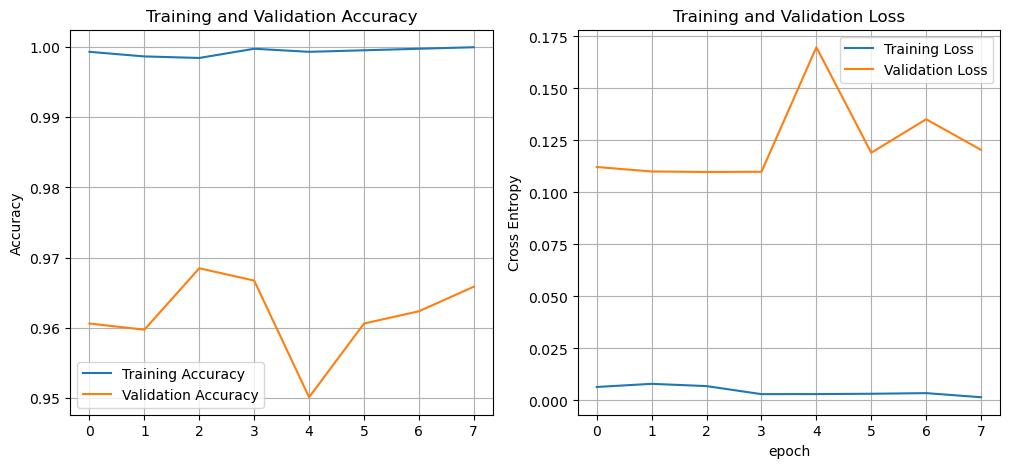

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.ylabel('Accuracy')
plt.grid()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

### 4.8. Prediction for Test dataset

In [58]:
y_true, y_pred_probabilities = eval_model_on_test(model_vgg)

Found 1311 files belonging to 4 classes.
1/1 [==============================] - 0s 26ms/step


### 4.9. Classification Report & Confusion Matrix

Confusion Matrix:
 [[285  14   0   1]
 [  4 293   5   4]
 [  0   1 404   0]
 [  0   2   0 298]]
--------------------------------------------------------------------------------
Accuracy score for Test dataset:
 0.9763539282990084
--------------------------------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       300
  meningioma       0.95      0.96      0.95       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.97      0.98      1311
weighted avg       0.98      0.98      0.98      1311

--------------------------------------------------------------------------------


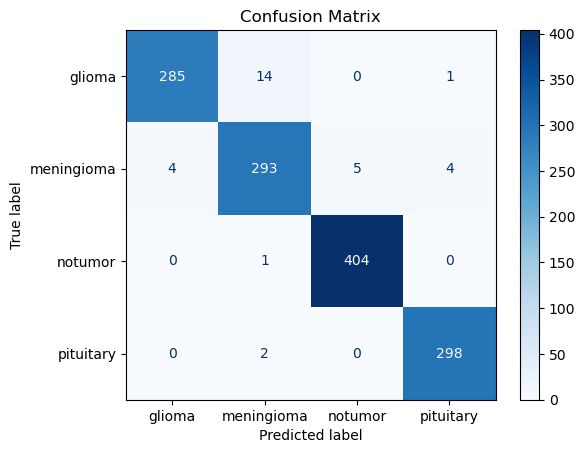

In [62]:
# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probabilities, axis=1)
# Calculate confusion matrix
confusion = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
print("Confusion Matrix:\n", confusion)
print("-"*80)
# Calculate precision, recall, and f1-score
report = classification_report(y_true, y_pred, target_names=classes)

print("Accuracy score for Test dataset:\n", accuracy)
print("-"*80)
print("\nClassification Report:\n", report)

print("-"*80)
#============================================================================================
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
plt.style.use("default")
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix')
plt.grid(visible=False)
plt.show();

## **5. Prediction for New Images**

(224, 224, 3)
(1, 224, 224, 3)
1/1 [==============================] - 0s 29ms/step
0
--------------------------------------------------------------------------------


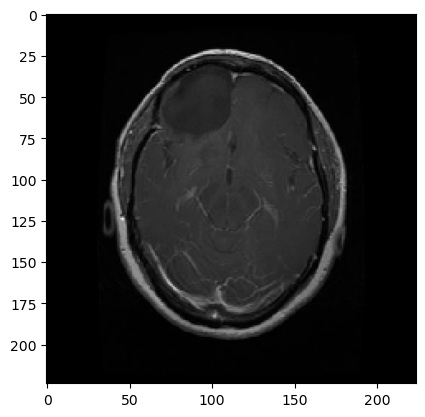

--------------------------------------------------------------------------------
Prediction:  glioma
--------------------------------------------------------------------------------


In [63]:
# predict for one image
from tensorflow.keras.preprocessing import image
img = image.load_img("Te-gl_0033.jpg",target_size=IMG_DIMS)
img_pred = img

type(img_pred)

img_pred = image.img_to_array(img_pred)  # convert from PIL image type to numpy array
print(img_pred.shape)

img_pred=np.expand_dims(img_pred, axis=0)   # since we are predicting for 1 image, hence we need to reshape the input to the model as expected by model
print(img_pred.shape)

class_predict = np.argmax(model_vgg.predict(img_pred))     # predict the class
print(class_predict)

if class_predict == 0:
    prediction = "glioma"
elif class_predict == 1:
    prediction = "meningioma"
elif class_predict == 2:
    prediction = "notumor"
elif class_predict == 3:
    prediction = "pituitary"

print("-"*80)
imgplot = plt.imshow(img)
plt.show()
print("-"*80)
print('Prediction: ', prediction)
print("-"*80)


## **6. Save the Trained DL model**

In [64]:
model_vgg.save("Brain_Tumor_Detector_VGG.h5")

**Save the Model Parameters for Deployment**

In [65]:
import pickle
pickle.dump(IMG_DIMS, open('IMG_DIMS.pkl','wb'))